# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

# Statistical imports
from scipy.stats import pointbiserialr
from scipy.stats.contingency import association
import statsmodels.api as sm

# import train_test_split function
from sklearn.model_selection import train_test_split

---
## 2. Load data

In [2]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


Now, lets import the price data

In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


---

## 3. Feature engineering



### Split Data into Training and Test Data

Before going too much further with feature enginnering, in order to avoid overfitting, it may help to split our data into training and test data.

In [6]:
# Drop the target column from client_prices
clients = df.copy()

X = clients.drop(columns = "churn")

# Save the target column as a series.
y = clients['churn']

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

We'll also add the X and Y trainng data together to make querying easier.

In [7]:
train = X_train.copy()
train['churn'] = y_train

To make identifying churn easier, we'll label 1 as yes and 0 as no in a separate column. 

In [9]:
# Assign new column with yes/no values based on churn: 1 => 'yes', and 0 => 'no'
train.loc[(train['churn'] == 1), 'churn_char'] = 'yes'
train.loc[(train['churn'] == 0), 'churn_char'] = 'no'

## Combine Datasets

To make comparisons easier, we'll combine the client training data with average price data. In order to do so, we'll run average prices for each customer in the price data, and merge that information with the client data. 

In [10]:
# Make a copy of each dataframe
prices = price_df.copy()

# Drop the dates from price data
prices_avg = prices.drop(columns = 'price_date')

# Group by ids, take the average of each price column, and reset index
prices_avg = pd.DataFrame(price_df.groupby(['id'], observed = False)[['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']].mean()).sort_values(by = 'id')
prices_avg = prices_avg.reset_index()

# Merge the two together, keeping only matching ids
train_cl_prices = pd.merge(train, prices_avg, on = 'id', how = 'inner')

train_cl_prices.shape

(11684, 51)


### Difference between off-peak prices in December and preceding January

The code below was created by a colleague to calculate the feature described above. We'll use this as an example to create features with predictive power.


In [12]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001




### Check Correlation of Columns with Churn

Let's check if his new feature has any correlation with churn in the training data. Since churn is technically a binary categorical variable, in order to check which numerical variables might have the most influence on churn, we'll run the correlations using the point-biserial correlation coefficient.

In [13]:
# Together data about prices, diffs in prices, and clients
cl_prices = pd.merge(train_cl_prices, diff, on = 'id', how = 'inner')

# List of numerical columns
col_list = ['churn', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix', 'forecast_price_pow_off_peak', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak']

# Select numerical columns
cp_nums = cl_prices[col_list]

In [14]:
# Create a function that takes a dataframe containing churn and outputs the pb_coeffs for all numerical columns and churn
def pb_corr(df):
    # Empty list for corr and p-values
    corr_ch = []
    
    # For each price value, point-biserial correlation coefficient correlation with churn
    for column in df:
        corr, p_val = pointbiserialr(df.churn, df[column])
        corr_ch.append([column, abs(corr), round(p_val, 6)])
    
    # Add the data to a dataframe, sort by coefficient in descending order
    ch_corr_df = pd.DataFrame(corr_ch).rename(columns = {0: 'attribute', 1: 'PB_corr_coeff', 2: 'p_value'}).sort_values(by = 'PB_corr_coeff', ascending = False).reset_index(drop = True)
    return ch_corr_df

In [15]:
# Find point-biserial correlation coeffecients for the numerical columns and churn
pb_corr(cp_nums)

,attribute,PB_corr_coeff,p_value
0,churn,1.000000,0.000000
1,margin_net_pow_ele,0.097129,0.000000
2,margin_gross_pow_ele,0.097072,0.000000
3,num_years_antig,0.076744,0.000000
4,price_peak_fix,0.054900,0.000000
5,price_mid_peak_var,0.054202,0.000000
6,price_mid_peak_fix,0.052592,0.000000
7,net_margin,0.045614,0.000001
8,cons_last_month,0.043831,0.000002
9,forecast_meter_rent_12m,0.043505,0.000003


The gross and net margin for power have the highest correlation with churn. The next is the number of years a client has been with the company. After that it's 'price_peak_fix', which is the price of power for the 2nd period. The energy price column that has the greatest correlation with churn is 'price_mid_peak_var', which is the price of energy for the 3rd period. Let's find the difference between each client's December 2015 price and January 2015 price for these columns. 

In [18]:
# Group prices by client and month for price_peak_fix and price_mid_peak_var
my_month_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_peak_fix': 'mean', 'price_mid_peak_var': 'mean'}).reset_index()

# Get january and december prices
jan2_prices = my_month_price_by_id.groupby('id').first().reset_index().rename(columns = {'price_peak_fix': 'jan_power_2nd', 'price_mid_peak_var': 'jan_energy_3rd' }).drop(columns = 'price_date')
dec2_prices = my_month_price_by_id.groupby('id').last().reset_index().rename(columns = {'price_peak_fix': 'dec_power_2nd', 'price_mid_peak_var': 'dec_energy_3rd'}).drop(columns = 'price_date')

# Calculate the difference
diff2 = pd.merge(dec2_prices, jan2_prices, on='id')
diff2['power_diff_2nd'] = diff2['dec_power_2nd'] - diff2['jan_power_2nd']
diff2['energy_diff_3rd'] = diff2['dec_energy_3rd'] - diff2['jan_energy_3rd']
diff2 = diff2[['id', 'power_diff_2nd','energy_diff_3rd']]
diff2.head()

,id,power_diff_2nd,energy_diff_3rd
0,0002203ffbb812588b632b9e628cc38d,0.097749,0.003487
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.097749,0.000763
4,00114d74e963e47177db89bc70108537,0.000000,0.000000


It may be useful to also find the difference between the max and min price for each customer. We'll do that for the four price columns with the highest point-biserial correlation coefficients.

In [16]:
# Make data frames with the max price for each customer for price_peak_fix and price_mid_peak_var
max_price_df = price_df.groupby(['id']).agg({'price_peak_fix': 'max', 'price_mid_peak_var': 'max', 'price_mid_peak_fix': 'max', 'price_peak_var': 'max'}).reset_index()
min_price_df = price_df.groupby(['id']).agg({'price_peak_fix': 'min', 'price_mid_peak_var': 'min', 'price_mid_peak_fix': 'min', 'price_peak_var': 'min'}).reset_index()

# Change column names
min_price_df = min_price_df.rename(columns = {'price_peak_fix': 'min_price_power2', 'price_mid_peak_var': 'min_price_energy3', 'price_mid_peak_fix': 'min_price_power3', 'price_peak_var': 'min_price_energy2'})
max_price_df = max_price_df.rename(columns = {'price_peak_fix': 'max_price_power2', 'price_mid_peak_var': 'max_price_energy3', 'price_mid_peak_fix': 'max_price_power3', 'price_peak_var': 'max_price_energy2'})

# Merge the two diff dfs
price_diff = pd.merge(min_price_df, max_price_df, on='id')

# Calculate the differences between max and min prices.
price_diff['mdiff_power2'] = price_diff.max_price_power2 - price_diff.min_price_power2
price_diff['mdiff_power3'] = price_diff.max_price_power3 - price_diff.min_price_power3
price_diff['mdiff_energy2'] = price_diff.max_price_energy2 - price_diff.min_price_energy2
price_diff['mdiff_energy3'] = price_diff.max_price_energy3 - price_diff.min_price_energy3

price_diff = price_diff[['id', 'mdiff_power2', 'mdiff_energy2', 'mdiff_power3', 'mdiff_energy3']]
price_diff.head(5)

,id,mdiff_power2,mdiff_energy2,mdiff_power3,mdiff_energy3
0,0002203ffbb812588b632b9e628cc38d,0.097749,0.004169,0.065166,0.003541
1,0004351ebdd665e6ee664792efc4fd13,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.097752,0.005120,0.065172,0.000817
4,00114d74e963e47177db89bc70108537,0.000000,0.000000,0.000000,0.000000


In [19]:
# merge this data with the cp_nums and client prices dataframes.
cl_prices = pd.merge(cl_prices, diff2, on = 'id')
cl_prices = pd.merge(cl_prices, price_diff, on = 'id')

# List of numerical columns
col_list = ['churn', 'mdiff_power2', 'mdiff_energy2', 'mdiff_power3', 'mdiff_energy3', 'power_diff_2nd', 'energy_diff_3rd', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power', 'cons_12m', 'forecast_discount_energy', 'forecast_meter_rent_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act', 'net_margin', 'num_years_antig', 'pow_max', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix', 'forecast_price_pow_off_peak', 'forecast_price_energy_off_peak', 'forecast_price_energy_peak']

# Select numerical columns
cp_nums = cl_prices[col_list]

# Find point-biserial correlation coeffecients for the numerical columns and churn
pb_corr(cp_nums)

,attribute,PB_corr_coeff,p_value
0,churn,1.000000,0.000000
1,margin_net_pow_ele,0.097129,0.000000
2,margin_gross_pow_ele,0.097072,0.000000
3,num_years_antig,0.076744,0.000000
4,price_peak_fix,0.054900,0.000000
5,price_mid_peak_var,0.054202,0.000000
6,price_mid_peak_fix,0.052592,0.000000
7,net_margin,0.045614,0.000001
8,cons_last_month,0.043831,0.000002
9,forecast_meter_rent_12m,0.043505,0.000003


Running differences this way actually seems to decrease the point-biserial correlation coefficient, but the p-value for the attibutes that are lower on the list is higher, so it may not be reliable for those columns. Perhaps there's another difference we can run that will make more of a difference. 

## Remove Irrelevant Columns



In [88]:
# Keep top 10 columns

train.origin_up.unique()

array(['lxidpiddsbxsbosboudacockeimpuepw',
       'kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'ldkssxwpmemidmecebumciepifcamkci', 'MISSING',
       'usapbepcfoloekilkwsdiboslwaxobdp',
       'ewxeelcelemmiwuafmddpobolfuxioce'], dtype=object)

In [89]:
# Take a look at the describe for those numerical columns

## Create New Features

Normalize the numerical variables using z-scores, and add them together, to see if that increases correlation. (I think consumption, price, power margin, and # yrs as a customer could together increase the correlation. Also look up a good way to do feature engineering for power variables.

In [90]:
train.margin_net_pow_ele.unique()

array([20.54, 30.  ,  8.76, ..., 41.5 , 39.15, 24.25])

### Churn Proportions in Price Quartiles

While the price columns seem to have different measures, what if we could see the percentile ranks for each period and compare them.

For the first two periods, we'll calculate the pertentages of clients who churned in each quartile. For example, for clients who had the lowest 25% of prices, what was the churn rate? But technically, they won't always be exact quartiles, since the price attributes have differing distributions.

After defining our function for proportions, we'll show the following for a few price variables. Then we'll move on to differences between percentile rankings.

In [21]:
def calc_proportions(df, column, Q1, Q2, Q3):
    
    # Calculate quartiles for the column for making cut
    my_groups = df[column].quantile([0.00, Q1, Q2, Q3, 1.00])

    # labels for the groups
    labels = ['Very Low','Low','Moderate','High']

    # bins for the cuts
    bins = [-1, my_groups[Q1], my_groups[Q2], my_groups[Q3], my_groups[1.00]]

    cut = 'cut_' + column

    # Assign the labels to a new column in df, our copy of the training features
    df[cut] = pd.cut(df[column], bins=bins, labels=labels)

    # Dataframe for churn values
    pr_churn = pd.DataFrame(df.churn_char.unique()).sort_values(by = 0).reset_index(drop = True)

    pr_churn = pr_churn.rename(columns = {0: "churn"})

    # How many from each price_cut group is in each churn category
    churn_mult = pd.DataFrame(df.groupby([cut, 'churn'], observed = False)['churn'].count())

    # Assign the grouped values to pr_churn dataframe
    pr_churn[labels[0]] = [churn_mult.xs(labels[0]).loc[0].values.max(), churn_mult.xs(labels[0]).loc[1].values.max()]
    pr_churn[labels[1]] = [churn_mult.xs(labels[1]).loc[0].values.max(), churn_mult.xs(labels[1]).loc[1].values.max()]
    pr_churn[labels[2]] = [churn_mult.xs(labels[2]).loc[0].values.max(), churn_mult.xs(labels[2]).loc[1].values.max()]
    pr_churn[labels[3]] = [churn_mult.xs(labels[3]).loc[0].values.max(), churn_mult.xs(labels[3]).loc[1].values.max()]
    
    # Total for each price_cut, so that percentages can be calculated
    total = pr_churn[labels[0]] + pr_churn[labels[1]] + pr_churn[labels[2]] + pr_churn[labels[3]]

    # Calculate percentages for each 
    ch_prop = pr_churn[pr_churn.columns[1:]].div(total, 0)*100

    # Add the churn column
    ch_prop['churn'] = pr_churn['churn']

    # Re-order the columns
    ch_prop = ch_prop[['churn', 'Very Low', 'Low', 'Moderate', 'High']]
    
    return ch_prop

In [32]:
calc_proportions(cl_prices, 'energy_diff_3rd', 0.30, 0.72, 0.89).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,64.991023,2.692998,23.070018,9.245961
1,no,70.870388,1.589404,19.176916,8.363292


In [175]:
# Calculate the proportions in each quartile for the power price during the 1st period.
calc_proportions(train, 'price_off_peak_fix', 0.25, 0.50, 0.75).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,29.174147,25.40395,19.748654,25.673250
1,no,26.017029,23.59508,25.979186,24.408704


In [176]:
# ENERGY PRICE 1ST PER
# Calculate the proportions in each quartile for the energy price during the 1st period
calc_proportions(train, 'price_off_peak_var', 0.25, 0.50, 0.75).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,27.468582,28.815081,20.736086,22.980251
1,no,24.768212,24.635762,25.392621,25.203406


In [177]:
# FORECASTED ENERGY PRICE 1ST PERIOD
# Calculate the proportions for forcasted energy price for the 1st period.
calc_proportions(train, 'forecast_price_energy_off_peak', 0.25, 0.50, 0.75).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,29.263914,26.929982,21.095153,22.710952
1,no,25.042573,24.701987,26.177862,24.077578


In [178]:
# POWER PRICE 1ST PERIOD
# Calculate the proportions for forcasted Power price for the 1st period.
calc_proportions(train, 'forecast_price_pow_off_peak', 0.25, 0.37, 0.88).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,38.061041,6.283662,42.908438,12.746858
1,no,31.967833,4.787133,51.778619,11.466414


In [179]:
# ENERGY PRICE 2ND PERIOD
# Calculate the proportions for energy price for the 2nd period.
calc_proportions(train, 'price_peak_var', 0.25, 0.50, 0.75).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,39.407540,6.104129,23.249551,31.238779
1,no,44.210028,6.272469,25.175024,24.342479


In [180]:
# FORECASTED ENERGY PRICE 2ND PERIOD
# Calculate the proportions for forcasted energy price for the 2nd period.
calc_proportions(train, 'forecast_price_energy_peak', 0.38, 0.60, 0.75).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,43.357271,8.976661,17.235189,30.430880
1,no,48.666036,12.450331,14.872280,24.011353


In [181]:
# POWER PRICE 2ND PERIOD
# Calculate the proportions for power price for the 2nd period.
calc_proportions(train, 'price_peak_fix', 0.25, 0.68, 0.88).sort_values(by = 'churn', ascending = False).reset_index(drop = True)

,churn,Very Low,Low,Moderate,High
0,yes,53.231598,9.335727,23.249551,14.183124
1,no,62.175970,6.480605,20.955535,10.387890


By inspecting the high and very low categories above, you can tell that the difference in proportions between those who churned, and those who didn't churn was only 1 to 3 percent for the first period. But when you look at the 2nd period (the last 3 dataframes), you can see that those differences range between 3 and 9, which means the differences increased. This shows that churn for the 2nd period has a greater impace on churn than the first period's prices. 

### Difference in Price

What if we could see which clients moved price category from one period to another, and whether that influenced churn. For example, if a client went from "Very Low" in the first period to "Low" or "Moderate" in the 2nd period, that would be considered being moved to a higher price catergory. 

Remember, the price categories are based on percentiles of prices in that period. In other words, the category is a client's price in relation to what prices other clients have. So, if we say the client's price category went up, it doensn't necessarily mean their price went up. It could just mean that the prices of other clients went down more than theirs did.

To store the difference in price category from the 1st period to the 2nd period, we'll create a new column for each set of columns, which tells whether the client's price category moved higher, lower, or stayed the same between two specified price periods. Then we'll graph the proportions for churn for that shift column.

In [182]:
# Create function that creates a new column that holds the change/shift values. Then use that column to calculate porportions for churn.
def calc_diff_proportions(df, col_after, col_before):

    # string variables for column names
    shift = 'shift_' + col_after
    col_after = 'cut_' + col_after
    col_before = 'cut_' + col_before
    
    # Create new column (shift) for holding the shift values
    df.loc[((df[col_after] > df[col_before])), shift] = 'higher' # type: ignore
    df.loc[((df[col_after] < df[col_before])), shift] = 'lower'
    df.loc[((df[col_after] == df[col_before])), shift] = 'same'

    # Multi-dimensional dataframe with counts grouped by shift and churn
    diff_mult = pd.DataFrame(df.groupby([shift, 'churn'], observed = False)['churn'].count())

    # Dataframe for churn values rearranged
    pr_churn = pd.DataFrame(df.churn_char.unique()).sort_values(by = 0).reset_index(drop = True)

    pr_churn = pr_churn.rename(columns = {0: "churn"})

    # Assign the grouped values to pr_churn dataframe
    pr_churn['higher'] = [diff_mult.xs('higher').loc[0].values.max(), diff_mult.xs('higher').loc[1].values.max()]
    pr_churn['lower'] = [diff_mult.xs('lower').loc[0].values.max(), diff_mult.xs('lower').loc[1].values.max()]
    pr_churn['same'] = [diff_mult.xs('same').loc[0].values.max(), diff_mult.xs('same').loc[1].values.max()]

    # Total for each price_cut, so that percentages can be calculated
    total = pr_churn['higher'] + pr_churn['lower'] + pr_churn['same']

    # Calculate percentages for each 
    ch_prop = pr_churn[pr_churn.columns[1:]].div(total, 0)*100

    # Add the churn column
    ch_prop['churn'] = pr_churn['churn']

    # Re-order the columns
    ch_prop = ch_prop[['churn', 'higher', 'lower', 'same']]
    
    return ch_prop

# Define a function for showing the shift in price category for clients from one period to another
def plot_diff_proportions(df, col_after, col_before, horiz, font):

    # Select the size of the graphs
    plt.rcParams['figure.figsize'] = 12, 5

    prop = calc_diff_proportions(df, col_after, col_before)
    
    # Plot the higher feature using a Horizontal Percentage Stacked Bar Chart
    prop.plot(
        x = 'churn',
        kind = 'barh',  # Horizontal
        stacked = True,
        title = 'Proportions for Category Change after ' + col_before + ' by churn',
        colormap = 'winter',
        alpha = 0.6   # Make colors a little lighter, so we can see the text better.
    )

    # Place the legend in the upper right
    plt.legend(loc="upper right", ncol = 2)
    
    # Label the x and y axes
    plt.xlabel("Proportion of Difference")
    plt.ylabel("Churn")
    
    # Loop to place percentage text on bars
    for n, x in enumerate([*prop.index.values]):
        for (proportion, x_loc) in zip(prop.iloc[x, 1:],
                                       prop.iloc[x, 1:].cumsum()):
            
            plt.text(x = x_loc + horiz,   # Horizontal location of percentage text
                    y = n,             # Vertical location of percentage text
                    s = f'{np.round(proportion, 1)}',   # The actual text to be shown
                    color = "black",
                    fontsize = font,
                    fontweight = "bold")
    
    plt.show()

Let's calculate the change in price of power from 1st to 2nd period.

In [183]:
# Calculate change in power price category from the 1st to 2nd period.
calc_diff_proportions(train, 'price_peak_fix', 'price_off_peak_fix').sort_values(by = 'churn', ascending = False)

,churn,higher,lower,same
1,yes,41.202873,53.231598,5.565530
0,no,34.058657,61.409650,4.531693


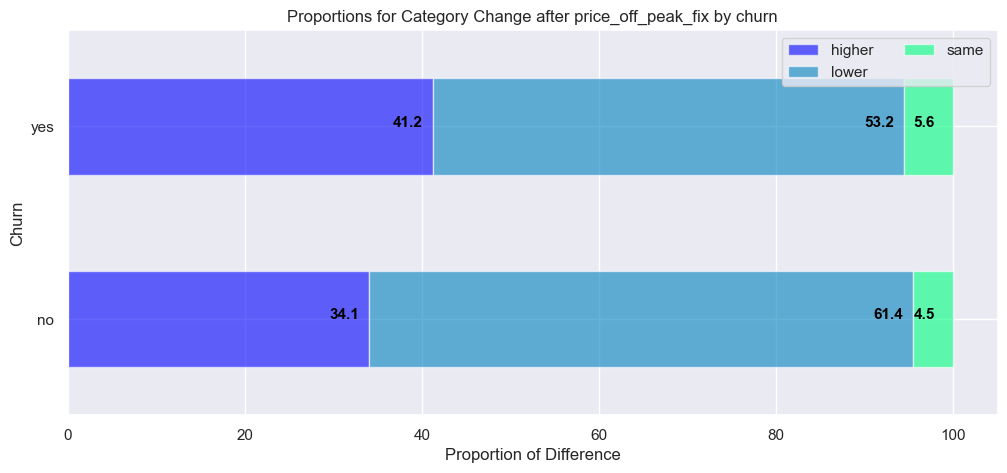

In [184]:
# Graph it
plot_diff_proportions(train, 'price_peak_fix', 'price_off_peak_fix', -4.5, 11)

The proportions of clients who changed price category over time tells us that change in price of power certainly effects churn. Clients who churned had about 7.1 percent more significant price increases than those those who did not churn. Those who churned had about 8.2 percent less price decreases. Those who stayed in the same price category still had a 1 percent more clients who churned. So, while it's not a huge difference, six percent is a fair amount of influence, so price sensitivity does have a fair amount of influence on customer churning

Let's try the same for energy.

In [185]:
# Calculate the change in energy price category for clients from the 1st to 2nd period.
calc_diff_proportions(train, 'price_peak_var', 'price_off_peak_var').sort_values(by = 'churn', ascending = False)

,churn,higher,lower,same
1,yes,45.242370,51.526032,3.231598
0,no,36.556291,60.000000,3.443709


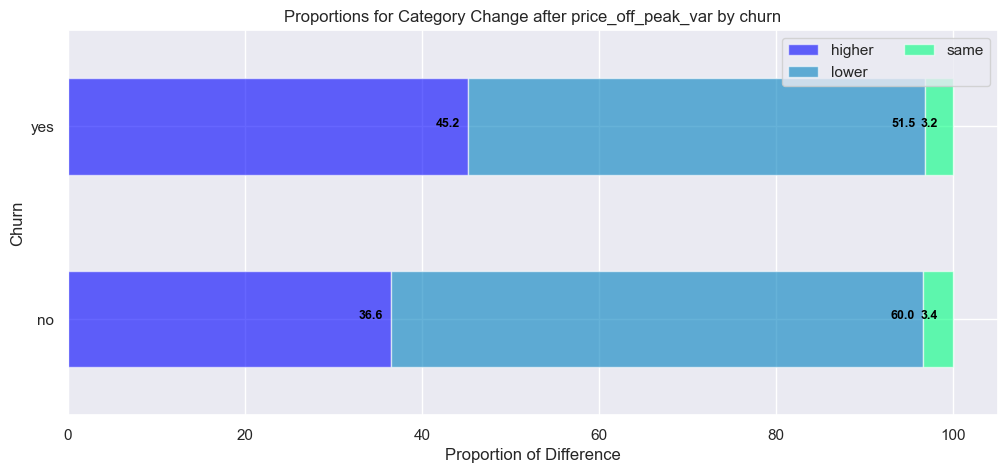

In [186]:
# Graph for energy
plot_diff_proportions(train, 'price_peak_var', 'price_off_peak_var', -3.7, 9)

We see a similar trend for energy prices, but the percent change is slightly larger. Clients who churned had over 8.6 percent more significant price increases compared to clients who did not churn. Clients who churned had over 8.4 percent less price decreases.

Let's check out the category changes for forecasted energy price from the 1st to 2nd period.

In [187]:
# Calculate change in forecasted energy price from the 1st to the 2nd period.
calc_diff_proportions(train, 'forecast_price_energy_peak', 'forecast_price_energy_off_peak').sort_values(by = 'churn', ascending = False)

,churn,higher,lower,same
1,yes,44.614004,52.782765,2.603232
0,no,36.300851,61.144749,2.554399


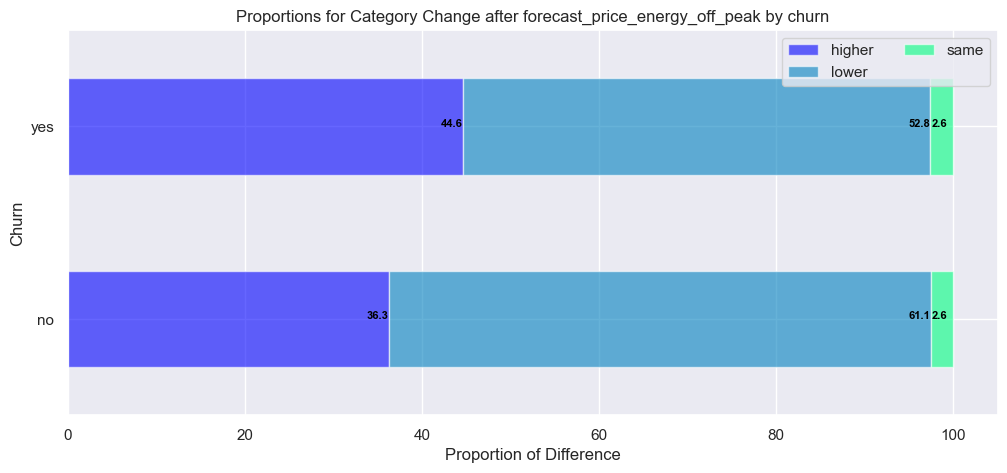

In [188]:
# Graph it
plot_diff_proportions(train, 'forecast_price_energy_peak', 'forecast_price_energy_off_peak', -2.5, 8)

Those who churned had 8.3 percent more increases in price_category, and 8.3 fewer price category decreases. 

In [189]:
train

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,cut_price_off_peak_fix,cut_price_off_peak_var,cut_forecast_price_energy_off_peak,cut_forecast_price_pow_off_peak,cut_price_peak_var,cut_forecast_price_energy_peak,cut_price_peak_fix,shift_price_peak_fix,shift_price_peak_var,shift_forecast_price_energy_peak
740,16484a791bc7b0b0745014d94658f607,foosdfpfkusacimwkcsosbicdxkicaua,6359,0,180,2010-12-23,2016-12-23,2015-11-01,2015-12-26,342.12,...,Low,Moderate,Moderate,High,Very Low,Very Low,Very Low,lower,lower,lower
3468,0a8e26d4bd2c493cc09757fea06923b9,usilxuppasemubllopkaafesmlibmsdf,21617,0,3110,2013-01-05,2017-01-05,2015-05-24,2016-01-06,2343.17,...,Very Low,Low,Low,Very Low,High,High,Low,higher,higher,higher
14013,06560abe331fc4159e0211ae5a0437a3,foosdfpfkusacimwkcsosbicdxkicaua,49752,0,0,2010-10-19,2016-10-19,2015-08-27,2015-10-20,2508.58,...,Moderate,Moderate,Moderate,Moderate,Very Low,Very Low,Very Low,lower,lower,lower
1188,6df7872e6c0d2cc1577a4940fab77d71,foosdfpfkusacimwkcsosbicdxkicaua,45711,0,3621,2013-04-11,2016-04-11,2013-04-11,2015-04-12,1907.91,...,High,High,High,Moderate,Low,Low,Very Low,lower,lower,lower
13098,1147b964762d3ea15c9692cbdb19c97d,foosdfpfkusacimwkcsosbicdxkicaua,11855,0,1166,2011-01-25,2017-01-25,2015-12-16,2016-01-26,1100.02,...,Very Low,Very Low,Very Low,Very Low,High,Moderate,Moderate,higher,higher,higher
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,7ff3bd708a7a34ad31d61983b1a4422c,usilxuppasemubllopkaafesmlibmsdf,38011,0,0,2011-07-12,2016-07-12,2015-06-20,2015-07-14,1162.10,...,Very Low,Very Low,Very Low,Very Low,High,Moderate,Moderate,higher,higher,higher
13418,1a30074a68a9a268154e7bf9d6824427,MISSING,16082,0,1104,2008-01-28,2016-01-28,2015-12-16,2015-01-30,1715.26,...,Very Low,Very Low,Very Low,Very Low,High,Moderate,Low,higher,higher,higher
5390,d0c1634d39b02b8a520d8257950e8aff,MISSING,14276,0,1091,2009-08-04,2016-11-08,2009-08-04,2015-11-09,1359.80,...,Very Low,Very Low,Very Low,Very Low,Moderate,High,Moderate,higher,higher,higher
860,f683797090b0bb98a7b29b6e2d4f2f8f,foosdfpfkusacimwkcsosbicdxkicaua,4100379,0,443297,2013-06-14,2016-06-14,2015-11-01,2015-06-23,684.70,...,Moderate,Moderate,Moderate,Moderate,Low,Very Low,Very Low,lower,lower,lower


## Combine Features